In [1]:
import keras
# import tensorflow as tf
from tensorflow import keras
import re
import numpy as np
import pandas as pd

from functools import partial
import matplotlib.pyplot as plt

from readTFRecords import *

# import tensorflow_hub as hub
# from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import EfficientNetB0


from sklearn.model_selection import train_test_split

# AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = "../input/train_tfrecords"
# BATCH_SIZE = 16
IMAGE_SIZE = (512, 512)
CLASSES = ['0', '1', '2', '3', '4']
EPOCHS = 12

FILENAMES = tf.io.gfile.glob(GCS_PATH + "/*tfrec")
split_ind = int(0.9 * len(FILENAMES))
# TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]

TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(FILENAMES, test_size=0.2, random_state=420)

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + "../input/test_tfrecords/*tfrec")
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Train TFRecord Files: 12
Validation TFRecord Files: 4
Test TFRecord Files: 0
Dataset: 16045 training images, 5352 validation images, 0.0 (unlabeled) test images


In [2]:
import efficientnet.keras as eff
from tensorflow.keras.experimental import CosineDecay

In [3]:
BATCH_SIZE = 12
epochs = 12

decay_steps = int(round(NUM_TRAINING_IMAGES/BATCH_SIZE))*epochs
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)

from keras.backend import sigmoid

class SwishActivation(tf.keras.layers.Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
# from tf.keras.layers import Activation
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

data_augmentation_layers = tf.keras.Sequential(
    [
#         tf.keras.layers.experimental.preprocessing.RandomCrop(height=512, width=512),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
        tf.keras.layers.experimental.preprocessing.RandomContrast((0.2,0.2)),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.4, width_factor=0.3)
    ], 
    name="img_augmentation"
)

def buildModel():
    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = data_augmentation_layers(inputs)
    # model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    model = eff.EfficientNetB0(include_top=False, input_tensor=x, weights='noisy-student')


    # Freeze the pretrained weights
    # model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(swish_act)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(swish_act)(x)

    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    
    return model

In [4]:
from sklearn.model_selection import KFold

In [5]:
kf = KFold(n_splits=5)

In [6]:
i = 1
for train_index, test_index in kf.split(FILENAMES):
    print(i)
    i+=1

1
2
3
4
5


In [7]:
decay_steps = int(round(NUM_TRAINING_IMAGES/BATCH_SIZE))*epochs
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)

hist = []

i = 1

for train_index, test_index in kf.split(FILENAMES):
    TRAINING_FILENAMES = [FILENAMES[t] for t in train_index]
    VALID_FILENAMES = [FILENAMES[t] for t in test_index]
    print(TRAINING_FILENAMES)
    print(VALID_FILENAMES)
    
    NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
    NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
    
    STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
    VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE
    
    train_dataset = get_validation_dataset(TRAINING_FILENAMES, BATCH_SIZE)
    valid_dataset = get_validation_dataset(VALID_FILENAMES, BATCH_SIZE)
    
    model = buildModel()
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint("EfficientNet_B0_cv_{}.ckpt".format(i), 
                                                monitor='val_accuracy', 
                                                verbose=1,
                                                save_best_only=True, 
                                                mode='max', save_freq='epoch',
                                               save_weights_only=True)

    # callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(cosine_decay), 
                  metrics=["accuracy"])
    
    
    
    history = model.fit(train_dataset, 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=epochs,
                        validation_data=valid_dataset,
                        validation_steps=VALID_STEPS, 
                       callbacks=[checkpoint])
    
    del model, train_dataset, valid_dataset
    tf.keras.backend.clear_session()
    
    hist.append(history)
    i+=1

['../input/train_tfrecords/ld_train13-1338.tfrec', '../input/train_tfrecords/ld_train12-1338.tfrec', '../input/train_tfrecords/ld_train08-1338.tfrec', '../input/train_tfrecords/ld_train02-1338.tfrec', '../input/train_tfrecords/ld_train11-1338.tfrec', '../input/train_tfrecords/ld_train01-1338.tfrec', '../input/train_tfrecords/ld_train04-1338.tfrec', '../input/train_tfrecords/ld_train15-1327.tfrec', '../input/train_tfrecords/ld_train07-1338.tfrec', '../input/train_tfrecords/ld_train10-1338.tfrec', '../input/train_tfrecords/ld_train00-1338.tfrec', '../input/train_tfrecords/ld_train03-1338.tfrec']
['../input/train_tfrecords/ld_train06-1338.tfrec', '../input/train_tfrecords/ld_train09-1338.tfrec', '../input/train_tfrecords/ld_train05-1338.tfrec', '../input/train_tfrecords/ld_train14-1338.tfrec']
Epoch 1/12
1337/1337 [==============================] - 622s 455ms/step - loss: 1.0658 - accuracy: 0.5980 - val_loss: 0.4628 - val_accuracy: 0.8496

Epoch 00001: val_accuracy improved from -inf to 0

Epoch 3/12
1448/1448 [==============================] - 632s 436ms/step - loss: 0.4754 - accuracy: 0.8340 - val_loss: 0.4107 - val_accuracy: 0.8618

Epoch 00003: val_accuracy improved from 0.85005 to 0.86178, saving model to EfficientNet_B0_cv_3.ckpt
Epoch 4/12
1448/1448 [==============================] - 634s 438ms/step - loss: 0.4396 - accuracy: 0.8462 - val_loss: 0.4336 - val_accuracy: 0.8610

Epoch 00004: val_accuracy did not improve from 0.86178
Epoch 5/12
1448/1448 [==============================] - 629s 435ms/step - loss: 0.4245 - accuracy: 0.8549 - val_loss: 0.4071 - val_accuracy: 0.8625

Epoch 00005: val_accuracy improved from 0.86178 to 0.86252, saving model to EfficientNet_B0_cv_3.ckpt
Epoch 6/12
1448/1448 [==============================] - 630s 435ms/step - loss: 0.4077 - accuracy: 0.8591 - val_loss: 0.3676 - val_accuracy: 0.8837

Epoch 00006: val_accuracy improved from 0.86252 to 0.88373, saving model to EfficientNet_B0_cv_3.ckpt
Epoch 7/12
1448/1448 [=====================

1448/1448 [==============================] - 635s 438ms/step - loss: 0.3584 - accuracy: 0.8757 - val_loss: 0.3537 - val_accuracy: 0.8755

Epoch 00009: val_accuracy improved from 0.87051 to 0.87550, saving model to EfficientNet_B0_cv_5.ckpt
Epoch 10/12
1448/1448 [==============================] - 637s 440ms/step - loss: 0.3182 - accuracy: 0.8922 - val_loss: 0.3576 - val_accuracy: 0.8767

Epoch 00010: val_accuracy improved from 0.87550 to 0.87675, saving model to EfficientNet_B0_cv_5.ckpt
Epoch 11/12
1448/1448 [==============================] - 634s 438ms/step - loss: 0.3290 - accuracy: 0.8856 - val_loss: 0.3751 - val_accuracy: 0.8645

Epoch 00011: val_accuracy did not improve from 0.87675
Epoch 12/12
1448/1448 [==============================] - 636s 439ms/step - loss: 0.3174 - accuracy: 0.8920 - val_loss: 0.3708 - val_accuracy: 0.8725

Epoch 00012: val_accuracy did not improve from 0.87675


In [9]:
hist[0].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

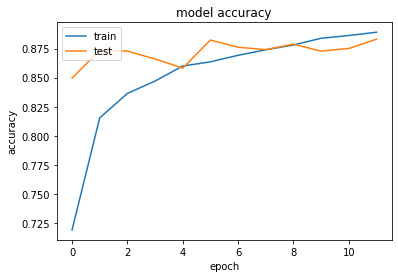

In [10]:
# summarize history for accuracy
plt.plot(hist[0].history['accuracy'])
plt.plot(hist[0].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

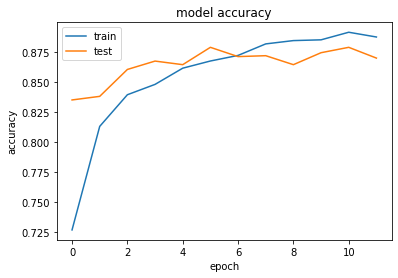

In [11]:
# summarize history for accuracy
plt.plot(hist[1].history['accuracy'])
plt.plot(hist[1].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

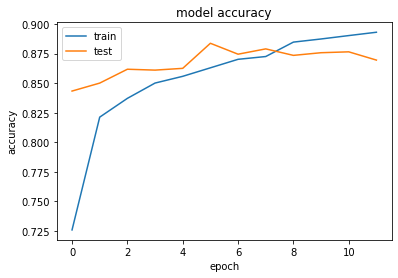

In [12]:
# summarize history for accuracy
plt.plot(hist[2].history['accuracy'])
plt.plot(hist[2].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

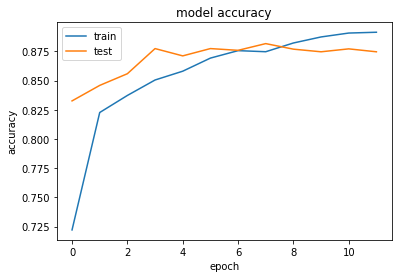

In [13]:
# summarize history for accuracy
plt.plot(hist[3].history['accuracy'])
plt.plot(hist[3].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

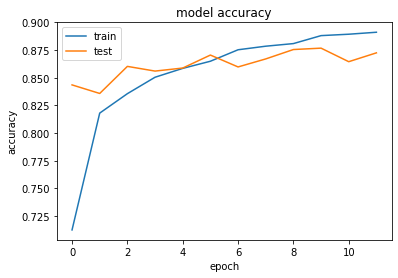

In [14]:
# summarize history for accuracy
plt.plot(hist[4].history['accuracy'])
plt.plot(hist[4].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
hist

In [19]:
import pandas as pd

In [24]:
df = pd.DataFrame.from_dict(hist[0].history)
df['cv'] = 0

for i in range(1,5):
    df_hold = pd.DataFrame.from_dict(hist[i].history)
    df_hold['cv'] = i
    df = df.append(df_hold)

In [32]:
df.groupby('cv')['val_accuracy'].agg({'max'})

,max
cv,
0,0.883034
1,0.878992
2,0.883733
3,0.881632
4,0.876747


In [31]:
df.groupby('cv')['val_accuracy'].agg({'max'}).mean()

max    0.880827
dtype: float64

In [33]:
df.to_csv('EfficientNetB0_cv_hist.csv', index=False)